# Predictive Maintenance for Electric Vehicles (EVs)
# Author of project: Akinmade Faruq
# Contact informations: www.linkedin.com/in/faruqakinmade
# Email: Fharuk147@gmail.com
# X website: https://x.com/EngrrrAkinmade


## Project Overview

The goal of this project is to develop a **predictive maintenance system for electric vehicles (EVs)** that minimizes unexpected breakdowns, improves maintenance scheduling, extends vehicle lifespan, enhances safety, and reduces operational costs for individual users and fleet operators.

With the growing adoption of EVs, **preemptively identifying potential component failures**—such as battery degradation, motor malfunctions, and charging system issues—is critical. This project leverages **machine learning** to analyze vehicle specifications and performance data to predict maintenance needs and potential failures.

---

## Project Workflow

### 1. Data Acquisition
- Load two primary datasets:
  1. **Electric Vehicle Specifications and Prices Dataset** — 360 observations with vehicle specs, performance metrics, and prices in Germany.
  2. **Electric Vehicle Specs Dataset (2025)** — an extensive dataset of modern EV specifications, including battery details, performance, drivetrain info, and more.

---

### 2. Data Preprocessing
- Clean and normalize both datasets (handle missing values, convert numeric fields, remove duplicates).
- Standardize column names and formats.
- Merge datasets on common attributes to create a unified dataset for analysis.

---

### 3. Exploratory Data Analysis (EDA)
- Visualize distributions of key features (battery capacity, efficiency, range, price, etc.).
- Examine relationships and correlations among variables.
- Identify trends and patterns relevant to EV performance and maintenance.

---

### 4. Feature Engineering
- Create meaningful features to improve model performance:
  - Cost per kilometer
  - Energy consumption per km
  - Fast-charging frequency
  - Interaction terms (e.g., battery capacity × efficiency)
- Derive features from telematics (if available), such as rolling battery health metrics, charging cycles, and usage intensity.

---

### 5. Model Development
- Select appropriate machine learning models:
  - Regression (predict time-to-failure)
  - Classification (predict failure risk within a time window)
  - Tree-based models (Random Forest, LightGBM) for tabular EV data
  - Neural networks for sequence or temporal telematics data (if available)
- Train models using cross-validation to ensure robustness.

---

### 6. Model Evaluation
- Evaluate models using relevant metrics:
  - Regression: RMSE, MAE, R²
  - Classification: Precision, Recall, F1-score, ROC-AUC
- Perform sensitivity analysis to understand feature impact on predictions.

---

### 7. Interpretability and Compliance
- Use SHAP or LIME to explain model predictions.
- Generate human-readable explanations for high-risk vehicles.
- Ensure compliance with regulatory requirements and maintain an audit trail.

---

### 8. Deployment and Monitoring
- Package the model for deployment (e.g., via Docker + FastAPI).
- Implement monitoring for model performance and data drift.
- Establish a retraining strategy using new data.

---

### 9. Documentation and Reporting
- Document all steps, methodologies, and findings.
- Provide actionable insights for fleet operators and EV owners.
- Share visualizations and summary reports to support decision-making.

---

By following this structured workflow, the project will deliver a robust **predictive maintenance system** that proactively identifies potential EV failures, guides maintenance decisions, and improves operational efficiency.


In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Preprocessing and modeling
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Machine Learning models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from xgboost import XGBRegressor, XGBClassifier

# Model evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, f1_score, precision_score, recall_score

# Model interpretation
import shap
# Optional: install shap if not installed
# !pip install shap

# Others
import warnings
warnings.filterwarnings('ignore')


In [4]:
# Load the datasets
df_prices = pd.read_csv("Electric Vehicle Specifications and Prices Dataset.csv")
df_specs = pd.read_csv("electric_vehicles_spec_2025.csv")

# Quick overview of the first dataset
print("=== Electric Vehicle Specifications and Prices Dataset ===")
print(df_prices.shape)
print(df_prices.head())
print(df_prices.info())
print(df_prices.describe())

# Quick overview of the second dataset
print("\n=== Electric Vehicle Specs Dataset (2025) ===")
print(df_specs.shape)
print(df_specs.head())
print(df_specs.info())
print(df_specs.describe())


=== Electric Vehicle Specifications and Prices Dataset ===
(360, 9)
   Battery                             Car_name  \
0     75.0  Tesla Model Y Long Range Dual Motor   
1     57.5                        Tesla Model 3   
2     60.5                           BYD ATTO 3   
3     61.7               MG MG4 Electric 64 kWh   
4     75.0  Tesla Model 3 Long Range Dual Motor   

                                       Car_name_link  Efficiency  Fast_charge  \
0  https://ev-database.org/car/1619/Tesla-Model-Y...         172        670.0   
1     https://ev-database.org/car/1991/Tesla-Model-3         137        700.0   
2        https://ev-database.org/car/1782/BYD-ATTO-3         183        370.0   
3  https://ev-database.org/car/1708/MG-MG4-Electr...         171        630.0   
4  https://ev-database.org/car/1992/Tesla-Model-3...         149        780.0   

   Price.DE.  Range  Top_speed  acceleration..0.100.  
0    59017.0    435        217                   5.0  
1    46220.0    420        2

In [5]:
# Data Preprocessing and Cleaning

# Rename columns in df_prices for consistency
df_prices = df_prices.rename(columns={
    'Battery': 'battery_capacity_kWh',
    'Efficiency': 'efficiency_wh_per_km',
    'Fast_charge': 'fast_charge_minutes',
    'Price.DE.': 'price_EUR',
    'Range': 'range_km',
    'Top_speed': 'top_speed_kmh',
    'acceleration..0.100.': 'acceleration_0_100_s'
})

# Convert numeric columns in df_prices
num_cols_prices = ['battery_capacity_kWh', 'efficiency_wh_per_km', 'fast_charge_minutes', 
                   'price_EUR', 'range_km', 'top_speed_kmh', 'acceleration_0_100_s']
for col in num_cols_prices:
    df_prices[col] = pd.to_numeric(df_prices[col], errors='coerce')

# Convert numeric columns in df_specs
num_cols_specs = ['battery_capacity_kWh', 'efficiency_wh_per_km', 'range_km', 
                  'top_speed_kmh', 'acceleration_0_100_s', 'fast_charging_power_kw_dc',
                  'torque_nm', 'number_of_cells', 'towing_capacity_kg']
for col in num_cols_specs:
    if col in df_specs.columns:
        df_specs[col] = pd.to_numeric(df_specs[col], errors='coerce')

# Create a canonical key for merging: lowercased, stripped, alphanumeric only
import re

def create_model_key(series):
    return series.str.lower().str.replace(r'[^a-z0-9 ]','', regex=True).str.strip()

df_prices['model_key'] = create_model_key(df_prices['Car_name'])
df_specs['model_key'] = create_model_key(df_specs['brand'].fillna('') + ' ' + df_specs['model'].fillna(''))

# Handle missing values (simple approach for now)
df_prices['fast_charge_minutes'].fillna(df_prices['fast_charge_minutes'].median(), inplace=True)
df_prices['price_EUR'].fillna(df_prices['price_EUR'].median(), inplace=True)

df_specs['number_of_cells'].fillna(df_specs['number_of_cells'].median(), inplace=True)
df_specs['torque_nm'].fillna(df_specs['torque_nm'].median(), inplace=True)
df_specs['fast_charging_power_kw_dc'].fillna(df_specs['fast_charging_power_kw_dc'].median(), inplace=True)
df_specs['towing_capacity_kg'].fillna(0, inplace=True)

In [6]:
# Merge Datasets into a Unified Table

# Perform an outer merge on 'model_key'
df_merged = pd.merge(df_prices, df_specs, on='model_key', how='outer', suffixes=('_price', '_spec'))

# Quick inspection of the merged dataset
print("Merged dataset shape:", df_merged.shape)
print(df_merged.head())
print(df_merged.info())

# Optional: count of missing values per column
print("\nMissing values per column:")
print(df_merged.isnull().sum())


Merged dataset shape: (663, 32)
   battery_capacity_kWh_price                 Car_name  \
0                        37.8  Abarth 500e Convertible   
1                        37.8    Abarth 500e Hatchback   
2                         NaN                      NaN   
3                         NaN                      NaN   
4                        60.0                Aiways U5   

                                       Car_name_link  \
0  https://ev-database.org/car/1904/Abarth-500e-C...   
1  https://ev-database.org/car/1903/Abarth-500e-H...   
2                                                NaN   
3                                                NaN   
4         https://ev-database.org/car/1678/Aiways-U5   

   efficiency_wh_per_km_price  fast_charge_minutes  price_EUR  range_km_price  \
0                       168.0                370.0    40990.0           225.0   
1                       168.0                370.0    37990.0           225.0   
2                         NaN          

<Figure size 800x400 with 0 Axes>

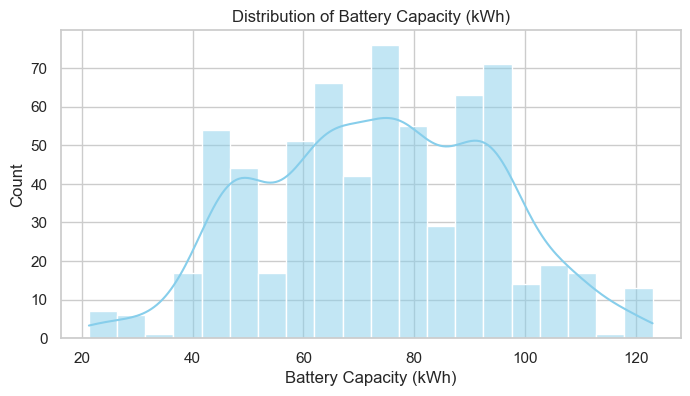

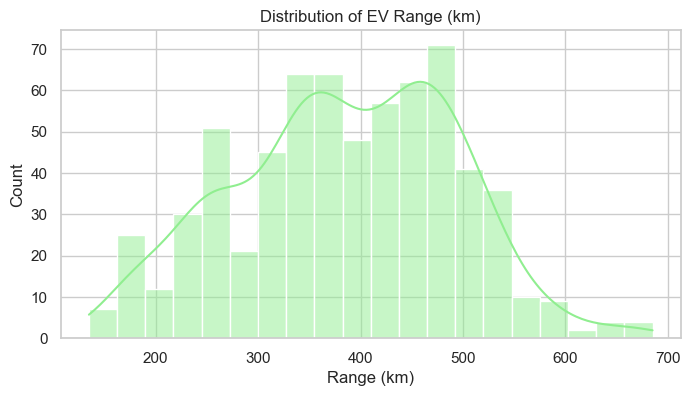

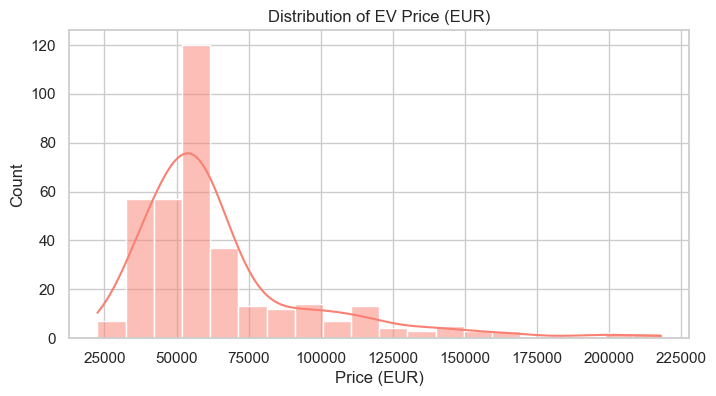

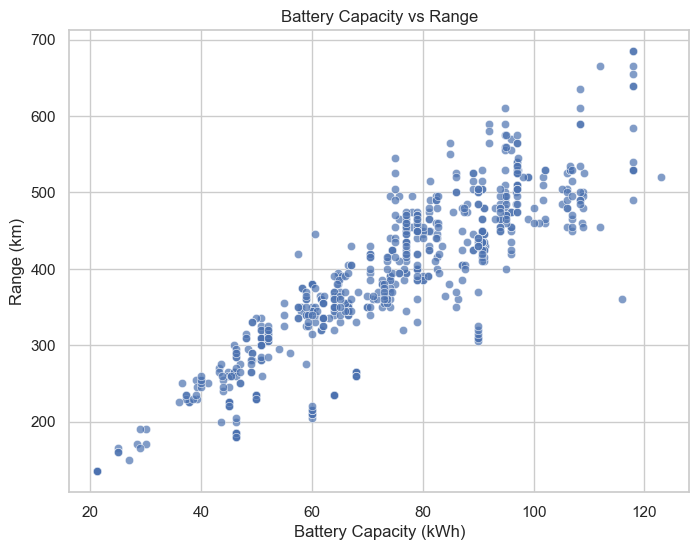

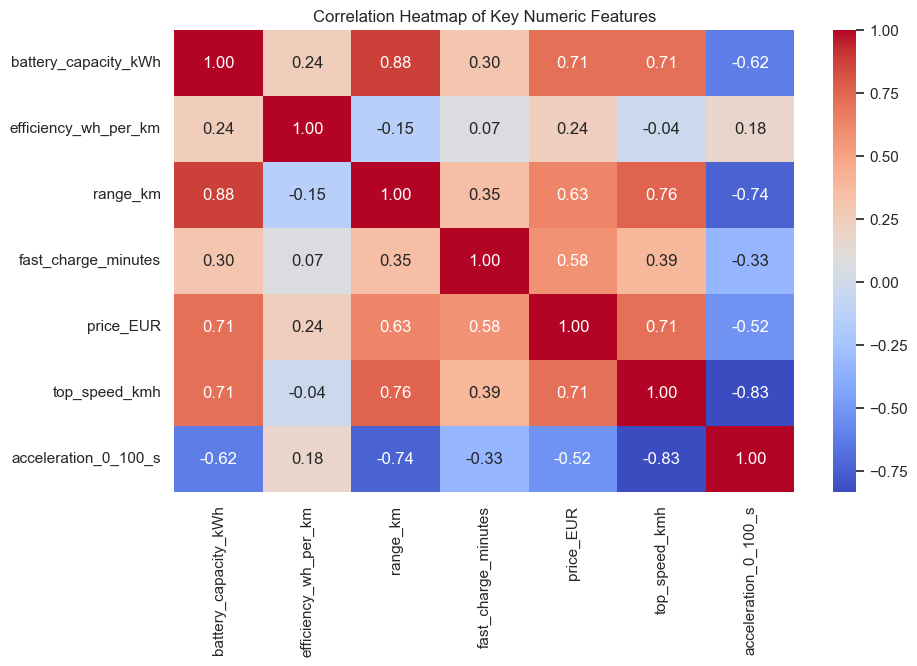

In [9]:
# EDA on Unified Columns

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# 1. Distribution of battery capacities
plt.figure(figsize=(8,4))
sns.histplot(df_merged['battery_capacity_kWh'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Battery Capacity (kWh)')
plt.xlabel('Battery Capacity (kWh)')
plt.ylabel('Count')
plt.show()

# 2. Distribution of EV ranges
plt.figure(figsize=(8,4))
sns.histplot(df_merged['range_km'], bins=20, kde=True, color='lightgreen')
plt.title('Distribution of EV Range (km)')
plt.xlabel('Range (km)')
plt.ylabel('Count')
plt.show()

# 3. Price distribution
plt.figure(figsize=(8,4))
sns.histplot(df_merged['price_EUR'], bins=20, kde=True, color='salmon')
plt.title('Distribution of EV Price (EUR)')
plt.xlabel('Price (EUR)')
plt.ylabel('Count')
plt.show()

# 4. Relationship between battery capacity and range
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_merged, x='battery_capacity_kWh', y='range_km', alpha=0.7)
plt.title('Battery Capacity vs Range')
plt.xlabel('Battery Capacity (kWh)')
plt.ylabel('Range (km)')
plt.show()

# 5. Correlation heatmap of key numeric features
numeric_cols = ['battery_capacity_kWh', 'efficiency_wh_per_km', 'range_km', 
                'fast_charge_minutes', 'price_EUR', 'top_speed_kmh', 'acceleration_0_100_s']
plt.figure(figsize=(10,6))
sns.heatmap(df_merged[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Key Numeric Features')
plt.show()


In [11]:
print(df_merged.columns)


Index(['battery_capacity_kWh_price', 'Car_name', 'Car_name_link',
       'efficiency_wh_per_km_price', 'fast_charge_minutes', 'price_EUR',
       'range_km_price', 'top_speed_kmh_price', 'acceleration_0_100_s_price',
       'model_key', 'brand', 'model', 'top_speed_kmh_spec',
       'battery_capacity_kWh_spec', 'battery_type', 'number_of_cells',
       'torque_nm', 'efficiency_wh_per_km_spec', 'range_km_spec',
       'acceleration_0_100_s_spec', 'fast_charging_power_kw_dc',
       'fast_charge_port', 'towing_capacity_kg', 'cargo_volume_l', 'seats',
       'drivetrain', 'segment', 'length_mm', 'width_mm', 'height_mm',
       'car_body_type', 'source_url', 'battery_capacity_kWh',
       'efficiency_wh_per_km', 'range_km', 'top_speed_kmh',
       'acceleration_0_100_s'],
      dtype='object')


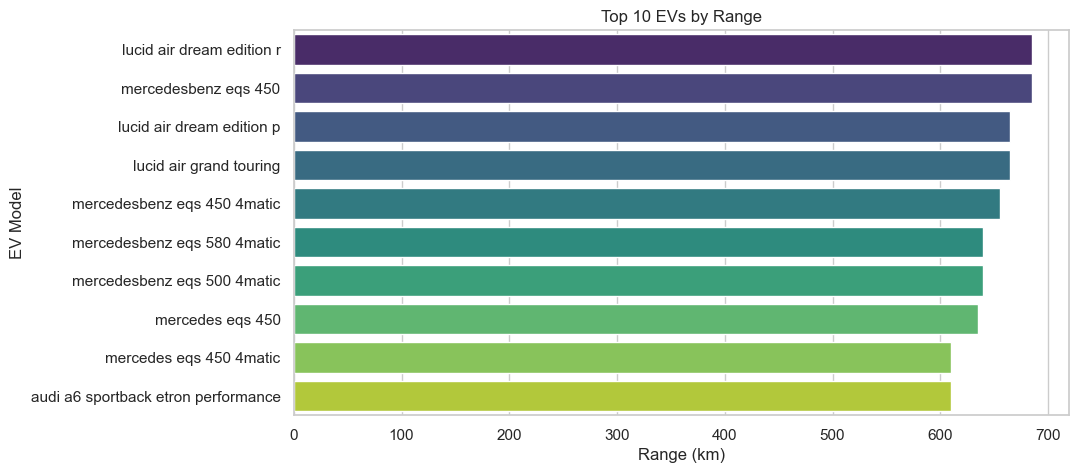

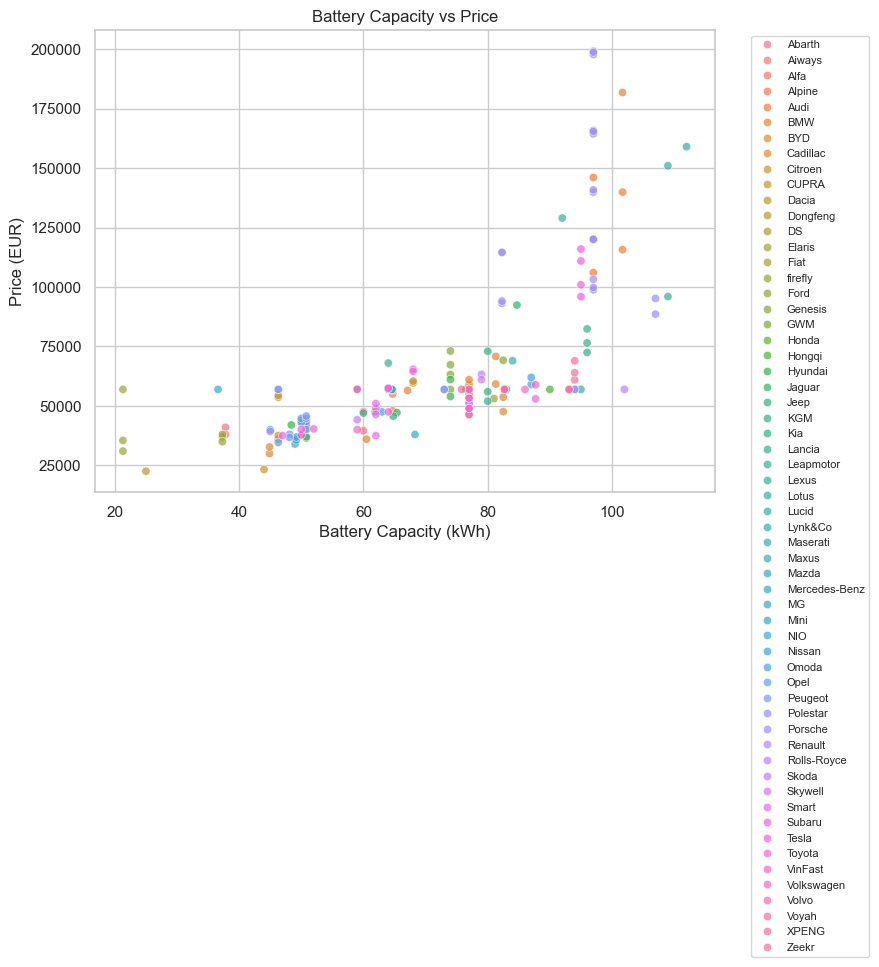

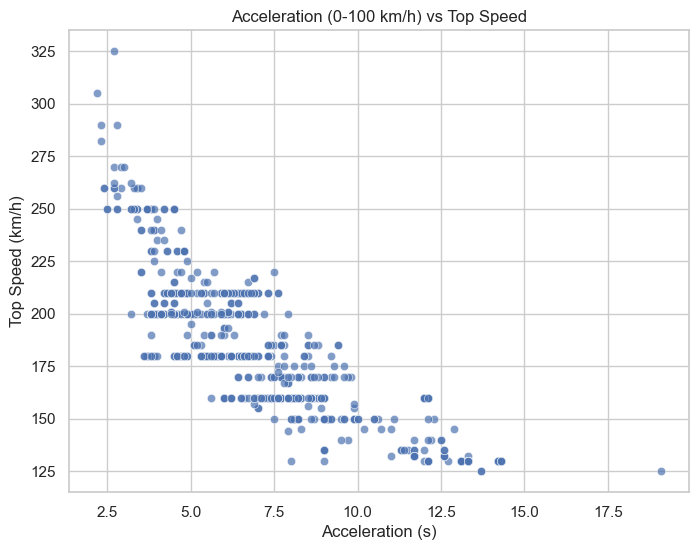

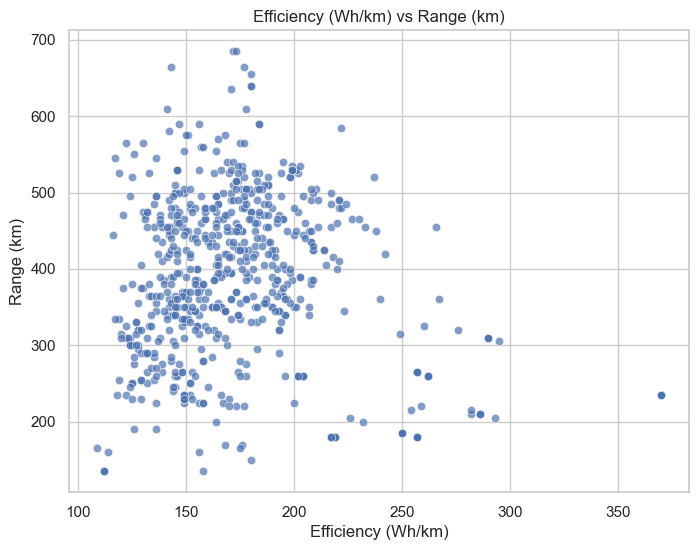

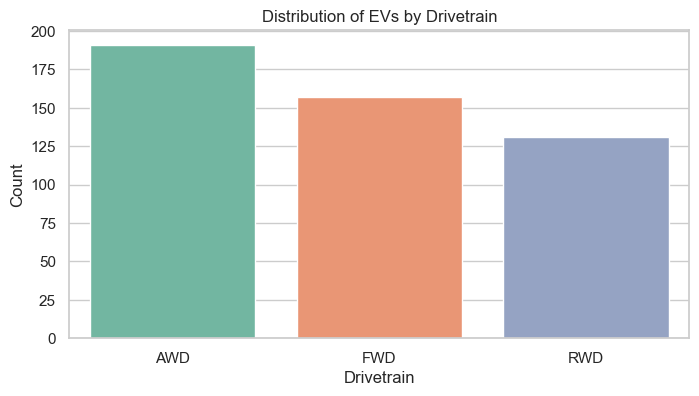

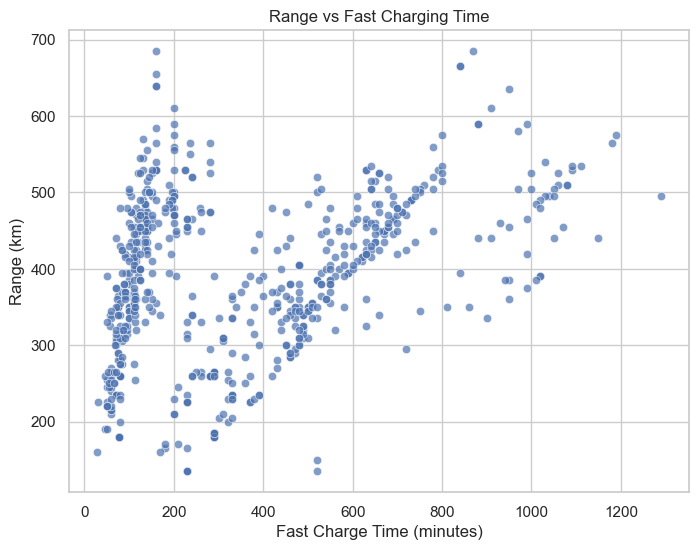

In [13]:
#  EDA on Unified Columns
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# 1. Top 10 EVs by Range
top_range = df_merged[['model_key', 'brand', 'range_km']].sort_values(by='range_km', ascending=False).head(10)
plt.figure(figsize=(10,5))
sns.barplot(data=top_range, x='range_km', y='model_key', palette='viridis')
plt.title('Top 10 EVs by Range')
plt.xlabel('Range (km)')
plt.ylabel('EV Model')
plt.show()

# 2. Battery Capacity vs Price
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_merged, x='battery_capacity_kWh', y='price_EUR', hue='brand', alpha=0.7)
plt.title('Battery Capacity vs Price')
plt.xlabel('Battery Capacity (kWh)')
plt.ylabel('Price (EUR)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.show()

# 3. Acceleration vs Top Speed
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_merged, x='acceleration_0_100_s', y='top_speed_kmh', alpha=0.7)
plt.title('Acceleration (0-100 km/h) vs Top Speed')
plt.xlabel('Acceleration (s)')
plt.ylabel('Top Speed (km/h)')
plt.show()

# 4. Efficiency vs Range
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_merged, x='efficiency_wh_per_km', y='range_km', alpha=0.7)
plt.title('Efficiency (Wh/km) vs Range (km)')
plt.xlabel('Efficiency (Wh/km)')
plt.ylabel('Range (km)')
plt.show()

# 5. Distribution by Drivetrain
plt.figure(figsize=(8,4))
sns.countplot(data=df_merged, x='drivetrain', order=df_merged['drivetrain'].value_counts().index, palette='Set2')
plt.title('Distribution of EVs by Drivetrain')
plt.xlabel('Drivetrain')
plt.ylabel('Count')
plt.show()

# 6. Range vs Fast Charge Time
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_merged, x='fast_charge_minutes', y='range_km', alpha=0.7)
plt.title('Range vs Fast Charging Time')
plt.xlabel('Fast Charge Time (minutes)')
plt.ylabel('Range (km)')
plt.show()


In [14]:
# Feature Engineering for Predictive Maintenance

# 1. Cost per km (Price divided by Range)
df_merged['cost_per_km_EUR'] = df_merged['price_EUR'] / df_merged['range_km']

# 2. Energy consumption per km (Battery capacity divided by Range)
df_merged['energy_per_km_kWh'] = df_merged['battery_capacity_kWh'] / df_merged['range_km']

# 3. Range-to-battery ratio (km per kWh)
df_merged['range_per_kWh'] = df_merged['range_km'] / df_merged['battery_capacity_kWh']

# 4. Power-to-weight proxy (using torque if available)
df_merged['torque_per_cell'] = df_merged['torque_nm'] / df_merged['number_of_cells']

# 5. Fast charging efficiency (Range gained per minute of fast charging)
df_merged['range_per_fast_charge_min'] = df_merged['range_km'] / df_merged['fast_charge_minutes']

# 6. Performance index (Top speed divided by acceleration)
df_merged['performance_index'] = df_merged['top_speed_kmh'] / df_merged['acceleration_0_100_s']

# Quick check of new features
df_merged[['cost_per_km_EUR', 'energy_per_km_kWh', 'range_per_kWh', 
           'torque_per_cell', 'range_per_fast_charge_min', 'performance_index']].head()


,cost_per_km_EUR,energy_per_km_kWh,range_per_kWh,torque_per_cell,range_per_fast_charge_min,performance_index
0,182.177778,0.168000,5.952381,1.223958,0.608108,22.142857
1,168.844444,0.168000,5.952381,1.223958,0.608108,22.142857
2,NaN,0.181429,5.511811,3.382353,3.544304,33.898305
3,NaN,0.181429,5.511811,3.382353,3.544304,32.258065
4,125.596825,0.190476,5.250000,1.435185,0.828947,20.000000


In [15]:
# Data Preprocessing for Modeling
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Select features for predictive modeling
features = ['battery_capacity_kWh', 'efficiency_wh_per_km', 'range_km',
            'top_speed_kmh', 'acceleration_0_100_s', 'fast_charge_minutes',
            'cost_per_km_EUR', 'energy_per_km_kWh', 'range_per_kWh',
            'torque_per_cell', 'range_per_fast_charge_min', 'performance_index']

# Separate predictors (X) and target (for now, let's assume we predict 'range_km' as an example)
X = df_merged[features]
y = df_merged['range_km']

# Handle missing values with median imputation
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=features)

# Feature scaling
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=features)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Quick check
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)


Training set shape: (530, 12)
Testing set shape: (133, 12)


In [17]:
# Check for remaining missing values

# Check for any missing values
missing_counts = X_scaled.isnull().sum()
print("Missing values per feature:\n", missing_counts)

# Identify rows with any missing values
missing_rows = X_scaled[X_scaled.isnull().any(axis=1)]
print("\nRows with missing values:")
print(missing_rows)


Missing values per feature:
 battery_capacity_kWh         0
efficiency_wh_per_km         0
range_km                     0
top_speed_kmh                0
acceleration_0_100_s         0
fast_charge_minutes          0
cost_per_km_EUR              0
energy_per_km_kWh            0
range_per_kWh                0
torque_per_cell              0
range_per_fast_charge_min    0
performance_index            0
dtype: int64

Rows with missing values:
Empty DataFrame
Columns: [battery_capacity_kWh, efficiency_wh_per_km, range_km, top_speed_kmh, acceleration_0_100_s, fast_charge_minutes, cost_per_km_EUR, energy_per_km_kWh, range_per_kWh, torque_per_cell, range_per_fast_charge_min, performance_index]
Index: []


In [18]:
# Handle any remaining missing values

# Count missing values before
print("Missing values before handling:", X_scaled.isnull().sum().sum())

# Drop rows with any missing values
X_scaled_clean = X_scaled.dropna()
y_clean = y.loc[X_scaled_clean.index]  # Align target variable

# Verify
print("Shape after dropping missing rows:", X_scaled_clean.shape)
print("Missing values after handling:", X_scaled_clean.isnull().sum().sum())


Missing values before handling: 0
Shape after dropping missing rows: (663, 12)
Missing values after handling: 0


Random Forest Regression Performance:
RMSE: 0.78
MAE: 0.18
R²: 1.00


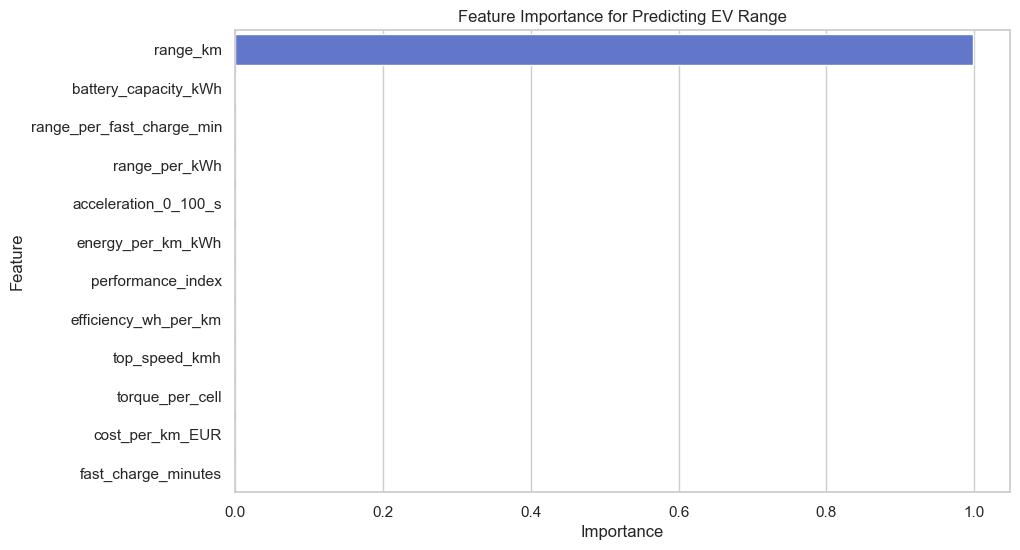

In [20]:
# Predictive Maintenance Model: Random Forest Regression
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Initialize Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=200, random_state=42)

# Train the model
rf_model.fit(X_scaled_clean, y_clean)

# Make predictions on the same dataset (or use a train/test split if preferred)
y_pred = rf_model.predict(X_scaled_clean)



# Evaluate model performance
mse = mean_squared_error(y_clean, y_pred)
rmse = np.sqrt(mse)  # Manual RMSE calculation
mae = mean_absolute_error(y_clean, y_pred)
r2 = r2_score(y_clean, y_pred)

print(f"Random Forest Regression Performance:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")

# Feature importance
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_scaled_clean.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='coolwarm')
plt.title('Feature Importance for Predicting EV Range')
plt.show()


Corrected Random Forest Regression Performance:
RMSE: 21.10
MAE: 14.43
R²: 0.96


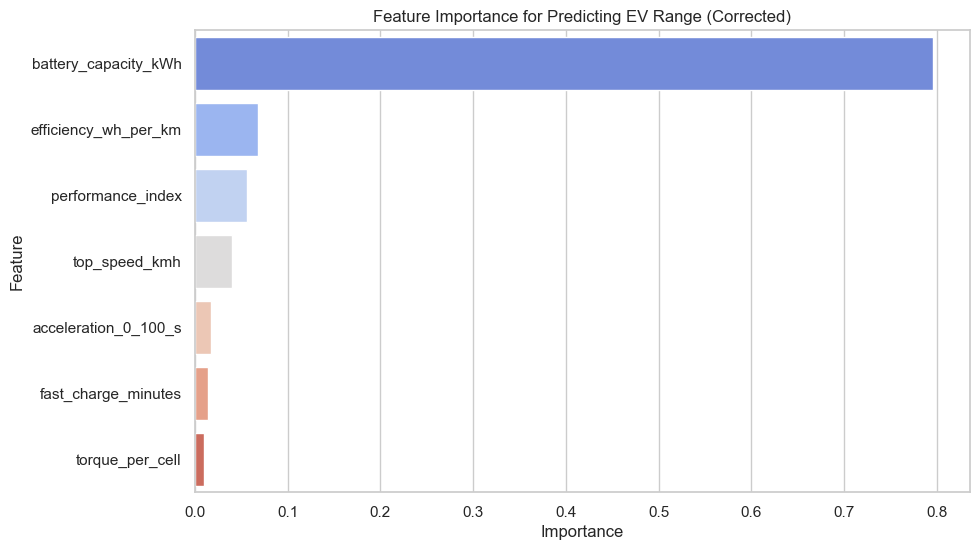

In [21]:
#  Predictive Maintenance Model

# Select safe features for modeling (exclude range_km and derived features)
safe_features = ['battery_capacity_kWh', 'efficiency_wh_per_km', 
                 'top_speed_kmh', 'acceleration_0_100_s', 
                 'fast_charge_minutes', 'torque_per_cell', 'performance_index']

# Predictor and target
X_safe = X_scaled_clean[safe_features]
y_safe = y_clean  # still predicting range_km for now

# Train/test split
X_train_safe, X_test_safe, y_train_safe, y_test_safe = train_test_split(
    X_safe, y_safe, test_size=0.2, random_state=42
)

# Initialize Random Forest Regressor
rf_model_safe = RandomForestRegressor(n_estimators=200, random_state=42)

# Train the model
rf_model_safe.fit(X_train_safe, y_train_safe)

# Predict
y_pred_safe = rf_model_safe.predict(X_test_safe)

# Evaluate performance
mse = mean_squared_error(y_test_safe, y_pred_safe)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_safe, y_pred_safe)
r2 = r2_score(y_test_safe, y_pred_safe)

print(f"Corrected Random Forest Regression Performance:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")

# Feature importance
importances = rf_model_safe.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_safe.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='coolwarm')
plt.title('Feature Importance for Predicting EV Range (Corrected)')
plt.show()


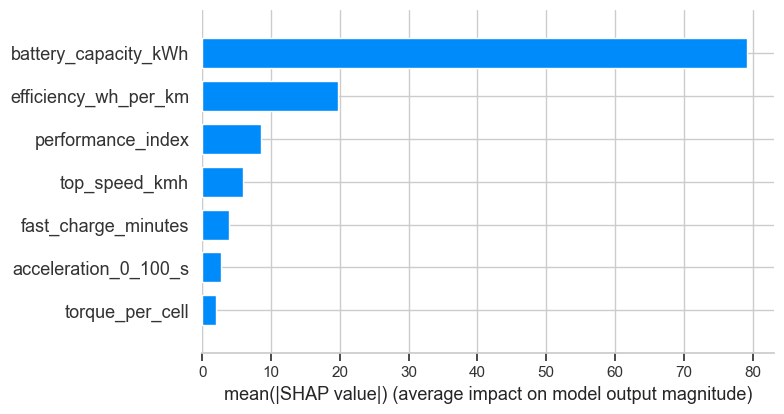

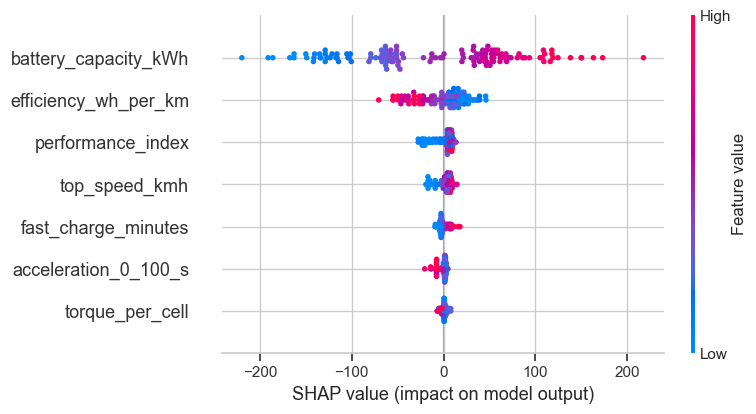

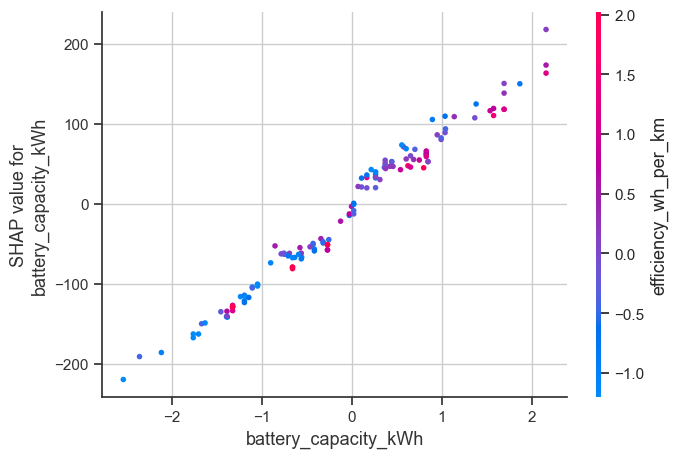

In [22]:
# SHAP Interpretability for Random Forest
import shap

# Initialize SHAP explainer
explainer = shap.TreeExplainer(rf_model_safe)
shap_values = explainer.shap_values(X_test_safe)

# Summary plot (global feature importance)
shap.summary_plot(shap_values, X_test_safe, plot_type="bar")

# Detailed summary plot (feature impact)
shap.summary_plot(shap_values, X_test_safe)

# Optional: SHAP dependence plot for battery capacity
shap.dependence_plot("battery_capacity_kWh", shap_values, X_test_safe)


# Predictive Maintenance Recommendations Based on SHAP Analysis

Based on the SHAP interpretability of the Random Forest model, we can derive the following actionable insights for EV maintenance:

1. **Battery Capacity (`battery_capacity_kWh`)**
   - Largest influence on predicted EV range.
   - **Recommendation:** Monitor battery health regularly, track degradation patterns, and schedule proactive maintenance or recalibration when capacity drops significantly.

2. **Efficiency (`efficiency_wh_per_km`)**
   - High impact on range predictions.
   - **Recommendation:** Ensure the vehicle’s energy consumption stays within expected ranges. Check for abnormal energy usage, which could indicate battery or drivetrain issues.

3. **Top Speed and Acceleration (`top_speed_kmh`, `acceleration_0_100_s`)**
   - Affect performance and energy draw.
   - **Recommendation:** Monitor driving patterns and vehicle logs. Aggressive driving may accelerate component wear, impacting battery and drivetrain longevity.

4. **Fast Charging Metrics (`fast_charge_minutes`)**
   - Influence performance-related metrics.
   - **Recommendation:** Track charging speed and frequency. Frequent fast-charging can increase thermal stress; schedule battery health checks if fast-charging is heavily used.

5. **Torque per Cell (`torque_per_cell`)**
   - Impacts drivetrain stress and component wear.
   - **Recommendation:** Monitor torque output for anomalies. Sudden changes can indicate motor or battery cell issues.

6. **Performance Index**
   - Composite metric influencing overall EV performance.
   - **Recommendation:** Use the performance index as a key indicator for predictive maintenance alerts.

---

**Overall Strategy:**
- Prioritize monitoring **battery health, efficiency, and torque metrics**.
- Schedule maintenance proactively based on deviations in key metrics.
- Use predictive alerts to reduce unexpected breakdowns, enhance safety, and optimize operational costs for EV fleets and individual users.


In [24]:
#  Interactive Dashboard for EV Maintenance
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display

# Ensure 'brand' column is string and handle missing values
df_merged['brand'] = df_merged['brand'].astype(str)

# Dropdown to select EV brand
brand_dropdown = widgets.Dropdown(
    options=['All'] + sorted(df_merged['brand'].unique().tolist()),
    value='All',
    description='Brand:',
    disabled=False
)

# Slider to adjust maintenance alert threshold
threshold_slider = widgets.FloatSlider(
    value=0.90,
    min=0.5,
    max=1.0,
    step=0.01,
    description='Alert Threshold:',
    readout_format='.2f'
)

# Function to update dashboard based on user input
def update_dashboard(selected_brand, threshold_factor):
    # Filter by brand
    if selected_brand != 'All':
        df_filtered = X_safe[df_merged['brand'] == selected_brand]
        y_filtered = y_safe[df_merged['brand'] == selected_brand]
    else:
        df_filtered = X_safe
        y_filtered = y_safe

    # Predict range
    predicted_range = rf_model_safe.predict(df_filtered)
    alert_condition = predicted_range < (threshold_factor * y_filtered)

    dashboard_df = pd.DataFrame({
        'EV_Model': df_merged.loc[df_filtered.index, 'model_key'],
        'Predicted_Range_km': predicted_range,
        'Actual_Range_km': y_filtered,
        'Maintenance_Alert': alert_condition
    })

    # Display table of alerts
    display(dashboard_df[dashboard_df['Maintenance_Alert'] == True])

    # Interactive bar chart
    fig = px.bar(
        dashboard_df[dashboard_df['Maintenance_Alert'] == True].sort_values(by='Predicted_Range_km'),
        x='Predicted_Range_km',
        y='EV_Model',
        color='Predicted_Range_km',
        color_continuous_scale='Reds',
        title=f'EVs Flagged for Maintenance (Threshold: {threshold_factor*100:.0f}%)'
    )
    fig.show()

# Create interactive widgets
widgets.interact(update_dashboard, selected_brand=brand_dropdown, threshold_factor=threshold_slider)


interactive(children=(Dropdown(description='Brand:', options=('All', 'Abarth', 'Aiways', 'Alfa', 'Alpine', 'Au…

<function __main__.update_dashboard(selected_brand, threshold_factor)>

In [25]:
# Save Trained Random Forest Model for Deployment
import joblib

# Define the filename
model_filename = "maintenance_for_ev_range_predictor.pkl"

# Save the trained model
joblib.dump(rf_model_safe, model_filename)

print(f"Trained model saved successfully as '{model_filename}'")


Trained model saved successfully as 'maintenance_for_ev_range_predictor.pkl'


# Predictive Maintenance for Electric Vehicles (EVs)
# Author of project: Akinmade Faruq
# Contact informations: www.linkedin.com/in/faruqakinmade
# Email: Fharuk147@gmail.com
# X website: https://x.com/EngrrrAkinmade


## Project Summary

This project focuses on developing a **predictive maintenance system for electric vehicles (EVs)** using machine learning techniques. The system predicts potential EV component failures and provides maintenance alerts to minimize unexpected breakdowns, optimize operational efficiency, enhance safety, and reduce costs for both individual users and fleet operators.

The predictive model utilizes comprehensive EV datasets that include specifications, performance metrics, pricing, and operational data. By analyzing these features, the model estimates key outcomes such as expected EV range and flags vehicles that may require maintenance attention.

---

## Key Features

- **Manual Entry & Batch Predictions:** Users can input EV specifications manually or upload a CSV file containing multiple EVs for batch predictions.
- **Engineered Features:** Computed features like `torque per cell` and `performance index` enhance model performance.
- **Maintenance Alerts:** The system flags EVs that may require maintenance based on a configurable threshold.
- **Feature Importance Visualization:** Provides insight into which features most influence predicted outcomes.
- **Downloadable Predictions:** Users can download prediction results as a CSV file for further analysis.

---

## Methodology Overview

1. **Data Collection & Preprocessing:** Merge and clean multiple EV datasets, handle missing values, and standardize numeric fields.
2. **Exploratory Data Analysis (EDA):** Identify trends and relationships in EV specifications and performance.
3. **Feature Engineering:** Compute derived features that improve model accuracy.
4. **Model Development:** Train Random Forest Regression to predict EV range and maintenance needs.
5. **Model Evaluation:** Validate predictions using RMSE, MAE, and R² metrics.
6. **Deployment:** Implement a Streamlit app (`Predictive_maintenance.py`) for interactive prediction and alerting.

---

## Usage

- Run the Streamlit app locally or on the cloud.
- Input EV data manually or upload a CSV file with multiple EVs.
- Adjust the maintenance alert threshold as needed.
- View predicted ranges, alerts, and feature importance visualizations.
- Download prediction results for reporting or further analysis.

---

## Impact

The project helps **proactively maintain EVs**, ensuring higher reliability, extended vehicle lifespan, improved safety, and cost reduction in operations for both private owners and fleet managers.
